Personalized Plotting Code

In [5]:
import pickle
import keras
import tensorflow as tf
from keras import backend as K
import numpy as np
import scipy.stats
import sys
import os
sys.path.append(os.path.abspath('../'))
import helpers

#from sklearn.metrics import r2_score
from time import strftime, localtime
import matplotlib
from matplotlib import pyplot as plt
import copy
%matplotlib inline
from helpers.normalization import normalize, denormalize, renormalize
from tqdm import tqdm
from helpers.data_generator import process_data, AutoEncoderDataGenerator
from helpers.custom_losses import denorm_loss, hinge_mse_loss
from helpers.custom_losses import percent_correct_sign, baseline_MAE
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from time import strftime, localtime
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from tqdm import tqdm_notebook
import seaborn as sns
from helpers.normalization import normalize, denormalize, renormalize
import scipy
from keras.utils.vis_utils import model_to_dot
from IPython.display import Image, display
import gspread
from oauth2client.service_account import ServiceAccountCredentials
from helpers.custom_init import downsample
from helpers.custom_reg import groupLasso
#from sklearn import decomposition
#from sklearn.metrics import r2_score

In [6]:
# CPU Only. 
os.environ["CUDA_VISIBLE_DEVICES"]="-1"  
num_cores = 1
config = tf.ConfigProto(intra_op_parallelism_threads=4*num_cores,
                        inter_op_parallelism_threads=4*num_cores, 
                        allow_soft_placement=True,
                        device_count = {'CPU' : 1,
                                        'GPU' : 0})
                        
session = tf.Session(config=config)
K.set_session(session)
keras.__version__

'2.2.5'

In [7]:
%matplotlib inline
font={'family': 'DejaVu Serif',
      'size': 18}
plt.rc('font', **font)
matplotlib.rcParams['figure.facecolor'] = (1,1,1,1)

In [15]:
matplotlib_colors = [(0.1215, 0.4667, 0.7058), # blue
                     (1.0000, 0.4980, 0.0549), # orange
                     (0.1725, 0.6275, 0.1725), # green
                     (0.8392, 0.1529, 0.1568), # red
                     (0.5804, 0.4039, 0.7412), # violet
                     (0.4980, 0.4980, 0.4980), # grey
                     (0.0902, 0.7450, 0.8117)] # cyan

matlab_colors=[(0.0000, 0.4470, 0.7410), # blue
               (0.8500, 0.3250, 0.0980), # reddish orange
               (0.9290, 0.6940, 0.1250), # yellow
               (0.4940, 0.1840, 0.5560), # purple
               (0.4660, 0.6740, 0.1880), # light green
               (0.3010, 0.7450, 0.9330), # cyan
               (0.6350, 0.0780, 0.1840)] # dark red

colorblind_colors = [(0.0000, 0.4500, 0.7000), # blue
                     (0.8359, 0.3682, 0.0000), # vermillion
                     (0.0000, 0.6000, 0.5000), # bluish green
                     (0.9500, 0.9000, 0.2500), # yellow
                     (0.3500, 0.7000, 0.9000), # sky blue
                     (0.8000, 0.6000, 0.7000), # reddish purple
                     (0.9000, 0.6000, 0.0000)] # orange

dashes = [(1.0, 0.0, 0.0, 0.0, 0.0, 0.0), # solid
          (3.7, 1.6, 0.0, 0.0, 0.0, 0.0), # dashed
          (1.0, 1.6, 0.0, 0.0, 0.0, 0.0), # dotted
          (6.4, 1.6, 1.0, 1.6, 0.0, 0.0), # dot dash
          (3.0, 1.6, 1.0, 1.6, 1.0, 1.6), # dot dot dash
          (6.0, 4.0, 0.0, 0.0, 0.0, 0.0), # long dash
          (1.0, 1.6, 3.0, 1.6, 3.0, 1.6)] # dash dash dot

from matplotlib import rcParams, cycler
matplotlib.rcdefaults()
rcParams['font.family'] = 'DejaVu Serif'
rcParams['mathtext.fontset'] = 'cm'
rcParams['font.size'] = 12
rcParams['figure.facecolor'] = (1,1,1,1)
rcParams['figure.figsize'] = (16,8)
rcParams['figure.dpi'] = 141
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['axes.labelsize'] =  'large'
rcParams['axes.titlesize'] = 'x-large'
rcParams['lines.linewidth'] = 2.5
rcParams['lines.solid_capstyle'] = 'round'
rcParams['lines.dash_capstyle'] = 'round'
rcParams['lines.dash_joinstyle'] = 'round'
rcParams['xtick.labelsize'] = 'large'
rcParams['ytick.labelsize'] = 'large'
# rcParams['text.usetex']=True
color_cycle = cycler(color=colorblind_colors)
dash_cycle = cycler(dashes=dashes)
rcParams['axes.prop_cycle'] =  color_cycle

labelsize=10
ticksize=8
# for i,c in enumerate(colorblind_colors):
#     plt.plot((i)*np.ones(5),c=c)

eq_sigs = {'temp':'etemp',
         'thomson_temp_EFITRT1':'etemp',
         'thomson_temp_EFITRT2':'etemp',
         'dens':'edens',
         'thomson_dens_EFITRT1':'edens',
         'thomson_dens_EFITRT2':'edens',
         'itemp':'itemp',
         'cerquick_temp_EFITRT1':'itemp',
         'cerquick_temp_EFITRT2':'itemp',
         'rotation':'rotation',
         'cerquick_rotation_EFITRT1':'rotation',
         'cerquick_rotation_EFITRT2':'rotation',
         'press_EFITRT1':'press',
         'press_EFITRT2':'press',
         'press_EFIT01':'press',
         'press_EFIT02':'press',
         'ffprime_EFITRT1':'ffprime',
         'ffprime_EFITRT2':'ffprime',
         'ffprime_EFIT01':'ffprime',
         'ffprime_EFIT02':'ffprime',
         'q':'q',
         'q_EFITRT1':'q',
         'q_EFITRT2':'q',
         'q_EFIT01':'q',
         'q_EFIT02':'q'}

labels = {'edens': '$n_e$ ($10^{19}/m^3$)',
          'etemp': '$T_e$ (keV)',
          'itemp': '$T_i$ (keV)',
          'rotation':'$\Omega$ (kHz)',
          'q':'$\iota$',
          'press':'$P$ (Pa)',
         'ffprime':"$FF'$"}

labels = {key:labels[val] for key, val in eq_sigs.items()}

scatter_titles = {'mean':'Mean',
                  'std':'Std Dev.',
                  'pca_1':'PCA Mode 1',
                  'pca_2':'PCA Mode 2',
                  'pca_3':'PCA Mode 3',
                  'pca_4':'PCA Mode 4',
                  'pca_5':'PCA Mode 5',
                  'pca_6':'PCA Mode 6',
                  'pca_2':'PCA Mode 2'}

Set Directory here:

In [28]:
#os.chdir('/scratch/gpfs/aiqtidar')
#print (os.path.abspath(os.curdir))
model = keras.models.load_model('/scratch/gpfs/aiqtidar/run_results_11_06/model-autoencoder_SET-dense_SDT-dense_CET-dense_CDT-dense_profiles-temp-dens-ffprime_EFIT02-press_EFIT02-q_EFIT02_act-pinj-curr-tinj-gasA_LB-0_LA-3_06Nov20-07-57_Scenario-3.h5', compile=True)
os.chdir(os.path.expanduser('/scratch/gpfs/aiqtidar/run_results_11_06/run_results_11_06_run/'))

files = [foo for foo in os.listdir() if '.pkl' in foo]
len(files)

OSError: Unable to open file (unable to open file: name = '/scratch/gpfs/aiqtidar/run_results_11_06/model-autoencoder_SET-dense_SDT-dense_CET-dense_CDT-dense_profiles-temp-dens-ffprime_EFIT02-press_EFIT02-q_EFIT02_act-pinj-curr-tinj-gasA_LB-0_LA-3_06Nov20-07-57_Scenario-3.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [27]:
files[19]

'model-autoencoder_SET-dense_SDT-dense_CET-dense_CDT-dense_profiles-temp-dens-ffprime_EFIT02-press_EFIT02-q_EFIT02_act-pinj-curr-tinj-gasA_LB-0_LA-3_06Nov20-07-57_Scenario-7_params.pkl'

In [12]:
for f in files:
    with open(f,'rb') as f:
        scenario = pickle.load(f,encoding='latin1')
        
with open(files[0],'rb') as f:
    scenario = pickle.load(f,encoding='latin1')

#sorted(scenario.keys())

['actuator_names',
 'batch_size',
 'control_decoder_kwargs',
 'control_decoder_type',
 'control_encoder_kwargs',
 'control_encoder_type',
 'control_latent_dim',
 'discount_factor',
 'dt',
 'epochs',
 'excluded_shots',
 'flattop_only',
 'lookahead',
 'lookback',
 'normalization_dict',
 'normalization_method',
 'nshots',
 'optimizer',
 'optimizer_kwargs',
 'process_data',
 'profile_downsample',
 'profile_length',
 'profile_names',
 'pruning_functions',
 'raw_data_path',
 'runname',
 'sample_step',
 'scalar_names',
 'shuffle_generators',
 'sig_names',
 'state_decoder_kwargs',
 'state_decoder_type',
 'state_encoder_kwargs',
 'state_encoder_type',
 'state_latent_dim',
 'steps_per_epoch',
 'train_frac',
 'u_weight',
 'uniform_normalization',
 'val_frac',
 'val_steps',
 'window_length',
 'window_overlap',
 'x_weight']

In [13]:
scenario['epochs']

200

In [ ]:
datapath = '/scratch/gpfs/jabbate/full_data/train_data_full.pkl'
with open(datapath,'rb') as f:
    rawdata = pickle.load(f,encoding='latin1')
    
traindata, valdata, normalization_dict = process_data(rawdata,
                                                              scenario['sig_names'],
                                                              scenario['normalization_method'],
                                                              scenario['window_length'],
                                                              scenario['window_overlap'],
                                                              scenario['lookback'],
                                                              scenario['lookahead'],
                                                              scenario['sample_step'],
                                                              scenario['uniform_normalization'],
                                                              1,
                                                              0,
                                                              scenario['nshots'],
                                                              2,
                                                              scenario['flattop_only'],
                                                              pruning_functions=scenario['pruning_functions'],
                                                              invert_q = scenario['invert_q'],
                                                              val_idx = 0,
                                                              excluded_shots=scenario['excluded_shots'],
                                                            randomize=False)
valdata = denormalize(valdata, normalization_dict)
valdata = renormalize(valdata, scenario['normalization_dict'])
generator = AutoEncoderDataGenerator(valdata,
                                               1,  
                                               scenario['profile_names'],
                                               scenario['actuator_names'],
                                               scenario['scalar_names'],
                                               scenario['lookback'],
                                               scenario['lookahead'],
                                               scenario['profile_downsample'],
                                               scenario['state_latent_dim'],
                                               scenario['discount_factor'],
                                               scenario['x_weight'],
                                               scenario['u_weight'],                                            
                                               scenario['shuffle_generators'])

In [17]:
# This block is for manual prediction generation
# Use when you want to experiment with different forecast horizons
# SKIP if you are using model.predict_generator()

def get_AB(model):
    A = model.get_layer('AB_matrices').get_weights()[1].T
    B = model.get_layer('AB_matrices').get_weights()[0].T
    return A,B

def get_submodels(model):
    from keras.models import Model
    state_encoder = model.get_layer('state_encoder_time_dist').layer.layers[-1]
    control_encoder = model.get_layer('ctrl_encoder_time_dist').layer.layers[-1]
    state_decoder = model.get_layer('state_decoder_time_dist').layer
    '''
    state_decoder = Model(model.get_layer('state_decoder_time_dist').layer.layers[0].input,
                             model.get_layer('state_decoder_time_dist').layer.layers[-2].get_output_at(1),
                             name='state_decoder')    
    control_decoder = Model(model.get_layer('ctrl_decoder_time_dist').layer.layers[0].input,
                                model.get_layer('ctrl_decoder_time_dist').layer.layers[-2].get_output_at(1),
                                name='control_decoder')
    '''
    return state_encoder, state_decoder, control_encoder


def get_autoencoder_predictions(state_encoder,state_decoder,control_encoder,A,B,scenario,inputs,**kwargs):
    import numpy as np
    state_inputs = {}
    x0 = {}
    for sig in scenario['profile_names']+scenario['scalar_names']:
        state_inputs[sig] = np.squeeze(inputs[0]['input_'+sig])
        if sig in scenario['profile_names']:
            x0['input_'+sig] = inputs[0]['input_'+sig][0][0].reshape((1,1,scenario['profile_length']))
        else:
            x0['input_'+sig] = inputs[0]['input_'+sig][0][0].reshape((1,1,1))
    control_inputs = {}
    for sig in scenario['actuator_names']:
        control_inputs['input_'+sig] = inputs[0]['input_'+sig]
    # encode control    
    T = scenario['lookback'] + scenario['lookahead'] 
    u = []
    for i in range(T):
        temp_input = {k:v[:,i].reshape((1,1,1)) for k,v in control_inputs.items()}
        u.append(np.squeeze(control_encoder.predict(temp_input)))
    # encode state and propogate
    x0 = np.squeeze(state_encoder.predict(x0))
    x = [x0]
    for i in range(scenario['lookahead']):
        x.append(A.dot(x[i])+B.dot(u[i]))
       
    # decode state and organize
    x_decoded = []
    for elem in x:
        x_decoded.append(state_decoder.predict(elem[np.newaxis,:]))
    state_predictions = {}
    residuals = {}
    for i, sig in enumerate(scenario['profile_names']):
        state_predictions[sig] = np.squeeze(np.dsplit((np.array([x_decoded[j] for j in range(len(x_decoded))])),5)[i])
        residuals[sig] = state_inputs[sig] - state_predictions[sig]

    return state_inputs, state_predictions, residuals


A, B = get_AB(model)
state_encoder, state_decoder, control_encoder = get_submodels(model)
model_err = {sig:[] for sig in scenario['profile_names']}
for i in range(len(generator)):
    print("{}/{}".format(i+1,len(generator)),end='\r')
    __,__,resids = get_autoencoder_predictions(state_encoder,state_decoder,control_encoder,A,B,scenario,generator[i])
    for sig in scenario['profile_names']:
        model_err[sig].append(np.abs(resids[sig][-1]))

NameError: name 'model' is not defined

# Extra

This loads the Model

In [14]:
model = keras.models.load_model(file_path, compile=False)
print('loaded model: ' + file_path.split('/')[-1])
file_path = file_path[:-3] + '_params.pkl'
with open(file_path, 'rb') as f:
    scenario = pickle.load(f, encoding='latin1')
print('loaded dict: ' + file_path.split('/')[-1])
print('with parameters: ' + str(scenario.keys()))

NameError: name 'file_path' is not defined

NameError: name 'inputs' is not defined

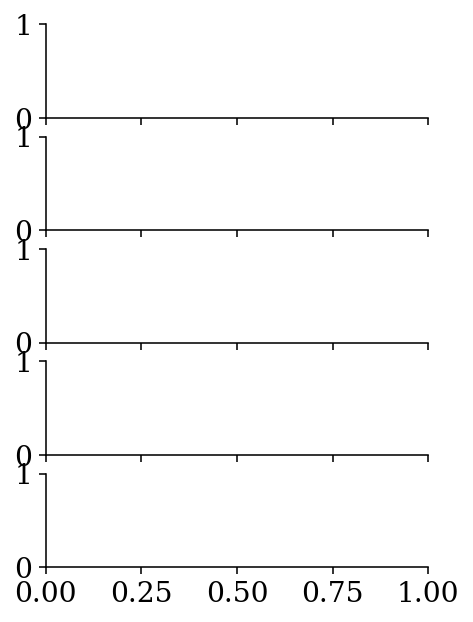

In [36]:
# good_indices = [5085,8351,1749,10746,7299,479,9980,5878,1297,12951]

# index = np.random.randint(len(data_generator))
# index = good_indices[9]
# print(index)
# inputs, targets,_ = data_generator[index]
profiles = ['dens','temp','rotation','q_EFIT01','press_EFIT01']

# shotnum = data_generator.cur_shotnum[0,0]
# shottime = data_generator.cur_times[0,-scenario['lookahead']-1]

predictions= scenario['predictions']
# predictions = {sig: pred for sig, pred in zip(scenario['target_profile_names'],predictions)}

fig, axes = plt.subplots(len(profiles),1,sharex=True, figsize=(3.5,5))
for j, profile in enumerate(profiles):
    ax = axes[j]
    inp = inputs['input_{}'.format(profile)].squeeze()
    true = inputs['input_{}'.format(profile)].squeeze() + targets['target_{}'.format(profile)].squeeze()
    pred = inputs['input_{}'.format(profile)].squeeze() + predictions[profile].squeeze()

    inp = helpers.normalization.denormalize_arr(inp,scenario['normalization_dict'][profile])
    true = helpers.normalization.denormalize_arr(true,scenario['normalization_dict'][profile])
    pred = helpers.normalization.denormalize_arr(pred,scenario['normalization_dict'][profile])

    ax.plot(psi,inp,lw=1.5,label='True, time $t$',c=colorblind_colors[1])
    ax.plot(psi,true,lw=1.5,label='True, time $t+200$ms',c='k',ls=':')
    ax.plot(psi,pred,lw=1.5,label='Prediction, time $t+200$ms',c=colorblind_colors[0])

    ax.set_ylabel(labels[profile],size=8)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.set_xticks([0,.5,1])
    ax.set_xlim(0,1)
    if j in [0,1,2]:
        ax.set_xlabel('$\\rho$',size=10)
    if j in [3,4]:
        ax.set_xlabel('$\psi$',size=10)
fig.align_ylabels(axes)
plt.subplots_adjust(top=.92, bottom=.18, hspace=0.5)
fig.suptitle("Shot# {}, $t=${} ms".format(int(shotnum), int(shottime)),fontsize=10)
fig.legend(handles=axes[0].lines,     
           labels=[line._label for line in axes[0].lines],  
           loc="upper center",
           bbox_to_anchor=(0.6, 0.12),
           frameon=False,
           mode=None,
           ncol=1,
          fontsize=8)
fig.savefig('images/timeslice_{}.png'.format(index),bbox_inches='tight',pad_inches=0.1)
fig.savefig('images/timeslice_{}.pdf'.format(index),bbox_inches='tight',pad_inches=0.1)

In [44]:
def plot_autoencoder_predictions_timestep(state_inputs, state_predictions, scenario, shot, timestep, filename=None, **kwargs):
    

    baseline = {k:v[0].reshape((scenario['profile_length'],)) for k,v in state_inputs.items()}
    true = {k:v[-1].reshape((scenario['profile_length'],)) for k,v in state_inputs.items()}
    pred = {k:v[-1].reshape((scenario['profile_length'],)) for k,v in state_predictions.items()}

    psi = np.linspace(0,1,scenario['profile_length'])
    ncols = len(scenario['profile_names'])
    nrows = 2
    figsize = (30,12)

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    fig.suptitle('Shot ' + str(int(shot)) + '   Time ' + str(int(timestep)) + '   Prediction Window ' 
                 + str(int(scenario['lookahead']*scenario['dt']*1000)),y=.95)
    for i, sig in enumerate(scenario['profile_names']):
        
        ax[0,i].plot(psi,pred[sig]-baseline[sig],psi,true[sig]-baseline[sig])
        ax[0,i].title.set_text(sig + ' (deltas)')
        ax[0,i].hlines(0,0,1)
        ax[0,i].legend(['predicted delta','true delta'])
        
        ax[1,i].plot(psi,pred[sig],psi,true[sig],psi, baseline[sig])
        ax[1,i].title.set_text(sig + ' (full)')
        ax[1,i].legend(['predicted','true','baseline'])
        
    fig.tight_layout()
    fig.subplots_adjust(top=0.88)    
    if filename:
        fig.savefig(filename,bbox_inches='tight')
        html = """<img src=\"""" + filename + """\"><p>"""
        return fig, html
    return fig 

# state_inputs = {}
# for sig in scenario['profile_names']+scenario['scalar_names']:
#     state_inputs['input_'+sig] = inputs['input_'+sig]

plot_autoencoder_predictions_timestep(scenario['profile_names'],scenario['predictions'],scenario,174670,5)

AttributeError: 'list' object has no attribute 'items'

In [42]:
scenario['true_output']['x_residual']

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])